In [211]:
#Imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import LeaveOneOut
from collections import Counter, defaultdict
import scipy.stats as stats

In [212]:
#Import Data
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

R^2: 0.9506


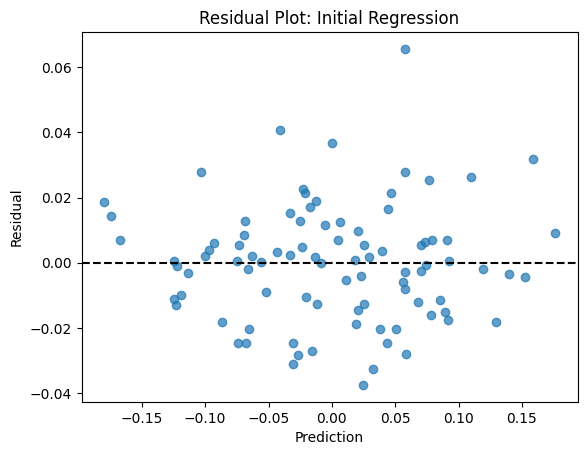

In [213]:
#Residual Scatter
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

residuals = y - y_pred

r2 = r2_score(y, y_pred)
print(f"R^2: {r2:.4f}")

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.title("Residual Plot: Initial Regression")
plt.show()

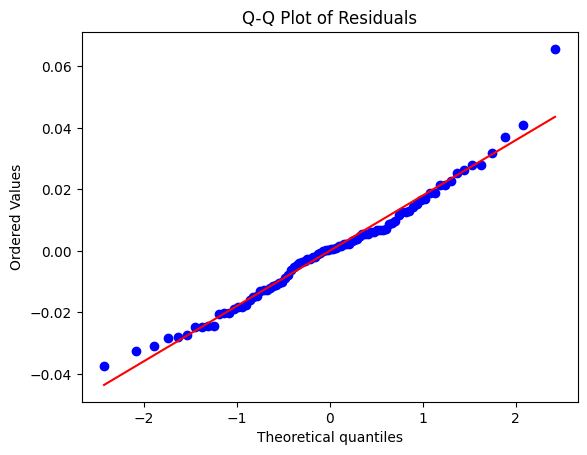

In [214]:
#Residual QQ Plot
stats.probplot(np.array(residuals).ravel(), dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

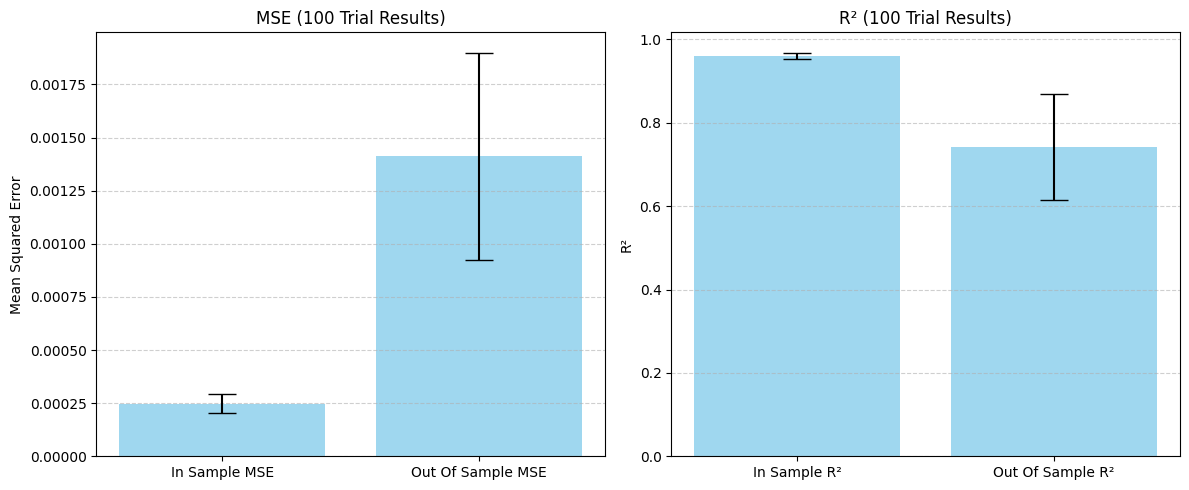

In [215]:
#Model 1: Simple Regression

in_sample_mse = []
out_sample_mse = []
in_sample_r2 = []
out_sample_r2 = []

#100 trials
for _ in range(100):
    #random train test splot each trial
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    #scale training data, use same transformation on test data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #simple regression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    #compute IS and OOS MSE and R^2
    in_sample_mse.append(mean_squared_error(y_train, y_train_pred))
    out_sample_mse.append(mean_squared_error(y_test, y_test_pred))
    in_sample_r2.append(r2_score(y_train, y_train_pred))
    out_sample_r2.append(r2_score(y_test, y_test_pred))

#mse mean and stddev across trials
mse_means = [np.mean(in_sample_mse), np.mean(out_sample_mse)]
mse_stds = [np.std(in_sample_mse), np.std(out_sample_mse)]

#R^2 means and stddev across trials
r2_means = [np.mean(in_sample_r2), np.mean(out_sample_r2)]
r2_stds = [np.std(in_sample_r2), np.std(out_sample_r2)]

#bar plots of mse and r^2 stats
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].bar(["In Sample MSE", "Out Of Sample MSE"], mse_means, yerr=mse_stds,
           capsize=10, color="skyblue", alpha=0.8)
axs[0].set_ylabel("Mean Squared Error")
axs[0].set_title("MSE (100 Trial Results)")
axs[0].grid(axis='y', linestyle='--', alpha=0.6)

axs[1].bar(["In Sample R²", "Out Of Sample R²"], r2_means, yerr=r2_stds,
           capsize=10, color="skyblue", alpha=0.8)
axs[1].set_ylabel("R²")
axs[1].set_title("R² (100 Trial Results)")
axs[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Lambda with minimum MSE: 0.08685113737513521
Lambda selected using 1-SE rule: 2.559547922699533


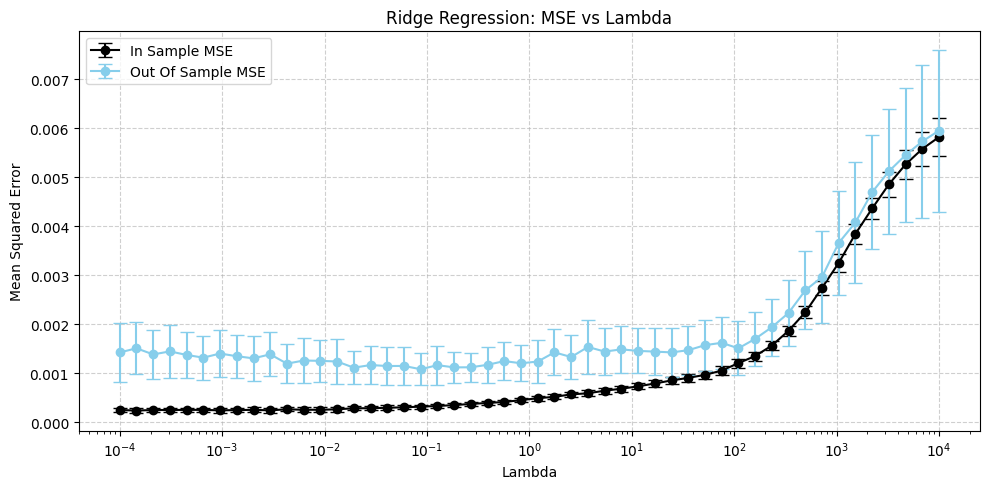

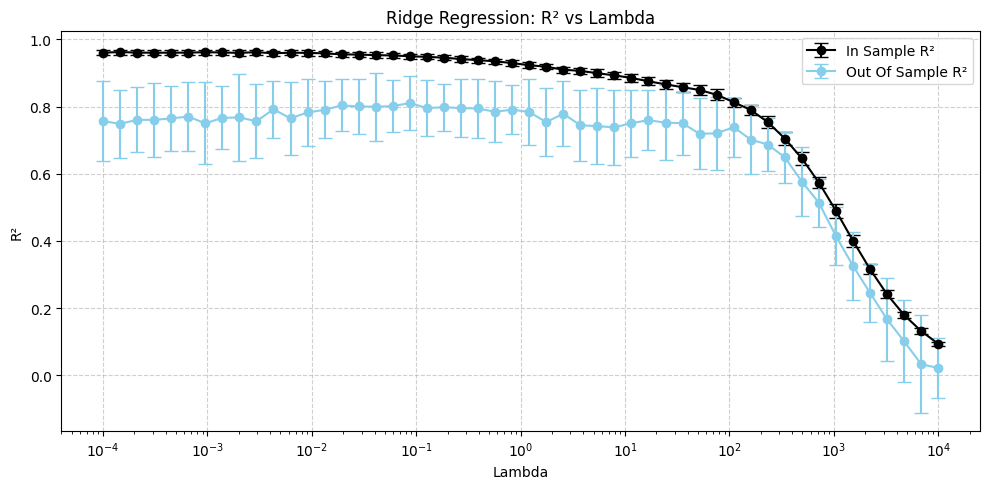

In [235]:
#Model 2: Ridge Regression

lambdas = np.logspace(-4, 4, 50)

in_sample_mse_means = []
out_sample_mse_means = []
in_sample_r2_means = []
out_sample_r2_means = []

in_sample_mse_stds = []
out_sample_mse_stds = []
in_sample_r2_stds = []
out_sample_r2_stds = []

#grid search across lambda
for alpha in lambdas:
    in_mse, out_mse = [], []
    in_r2, out_r2 = [], []

    #for each lambda, 100 trials, same process as before
    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        in_mse.append(mean_squared_error(y_train, y_train_pred))
        out_mse.append(mean_squared_error(y_test, y_test_pred))
        in_r2.append(r2_score(y_train, y_train_pred))
        out_r2.append(r2_score(y_test, y_test_pred))

    in_sample_mse_means.append(np.mean(in_mse))
    out_sample_mse_means.append(np.mean(out_mse))
    in_sample_r2_means.append(np.mean(in_r2))
    out_sample_r2_means.append(np.mean(out_r2))

    in_sample_mse_stds.append(np.std(in_mse))
    out_sample_mse_stds.append(np.std(out_mse))
    in_sample_r2_stds.append(np.std(in_r2))
    out_sample_r2_stds.append(np.std(out_r2))

#best lambda according to 1-SE rule
min_idx = np.argmin(out_sample_mse_means)
lambda_min = lambdas[min_idx]
min_mse = out_sample_mse_means[min_idx]
mse_threshold = min_mse + out_sample_mse_stds[min_idx]
candidate_indices = np.where(out_sample_mse_means <= mse_threshold)[0]
lambda_1se = lambdas[candidate_indices].max()

print(f"Lambda with minimum MSE: {lambda_min}")
print(f"Lambda selected using 1-SE rule: {lambda_1se}")

#plots of MSE and R^2 across lambda, with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(lambdas, in_sample_mse_means, yerr=in_sample_mse_stds, label='In Sample MSE',
             fmt='-o', capsize=5, color='k')
plt.errorbar(lambdas, out_sample_mse_means, yerr=out_sample_mse_stds, label='Out Of Sample MSE',
             fmt='-o', capsize=5, color='skyblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title('Ridge Regression: MSE vs Lambda')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.errorbar(lambdas, in_sample_r2_means, yerr=in_sample_r2_stds, label='In Sample R²',
             fmt='-o', capsize=5, color='k')
plt.errorbar(lambdas, out_sample_r2_means, yerr=out_sample_r2_stds, label='Out Of Sample R²',
             fmt='-o', capsize=5, color='skyblue')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('R²')
plt.title('Ridge Regression: R² vs Lambda')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Lambda with minimum MSE: 0.0001
Lambda selected using 1-SE rule: 0.005428675439323859


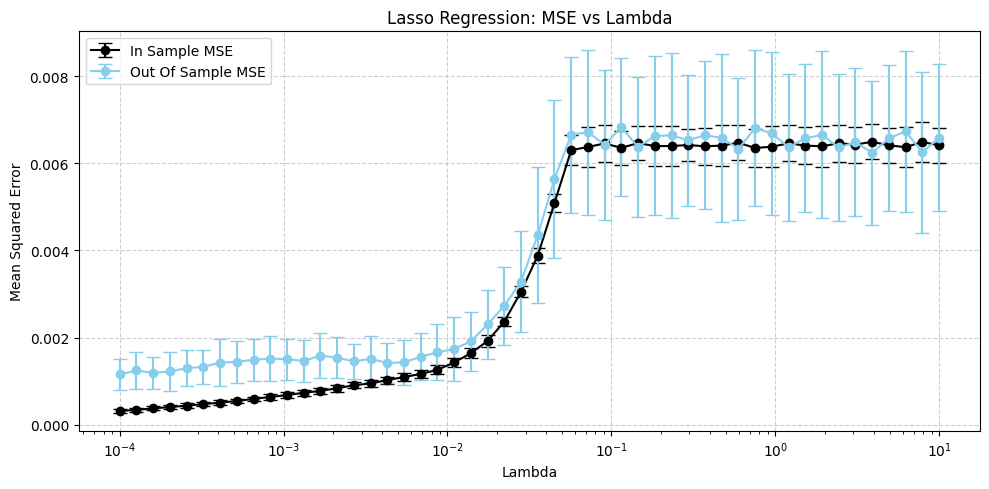

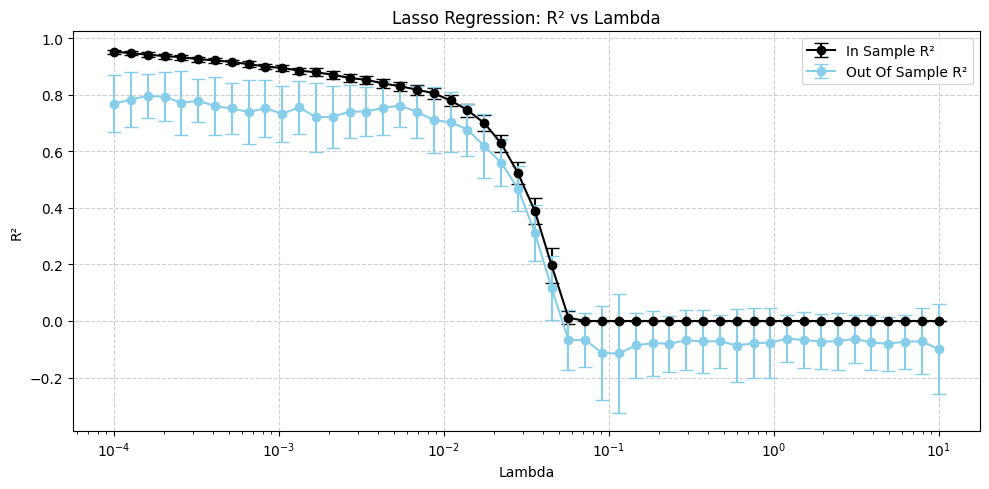

In [234]:
#Model 3: LASSO

#same exact process as before, just swap ridge for lasso
lambdas = np.logspace(-4, 1, 50)

in_sample_mse_means, out_sample_mse_means = [], []
in_sample_r2_means, out_sample_r2_means = [], []

in_sample_mse_stds, out_sample_mse_stds = [], []
in_sample_r2_stds, out_sample_r2_stds = [], []

for alpha in lambdas:
    in_mse, out_mse = [], []
    in_r2, out_r2 = [], []

    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        in_mse.append(mean_squared_error(y_train, y_train_pred))
        out_mse.append(mean_squared_error(y_test, y_test_pred))
        in_r2.append(r2_score(y_train, y_train_pred))
        out_r2.append(r2_score(y_test, y_test_pred))

    in_sample_mse_means.append(np.mean(in_mse))
    out_sample_mse_means.append(np.mean(out_mse))
    in_sample_r2_means.append(np.mean(in_r2))
    out_sample_r2_means.append(np.mean(out_r2))

    in_sample_mse_stds.append(np.std(in_mse))
    out_sample_mse_stds.append(np.std(out_mse))
    in_sample_r2_stds.append(np.std(in_r2))
    out_sample_r2_stds.append(np.std(out_r2))

min_idx = np.argmin(out_sample_mse_means)
lambda_min = lambdas[min_idx]
min_mse = out_sample_mse_means[min_idx]
mse_threshold = min_mse + out_sample_mse_stds[min_idx]
candidate_indices = np.where(out_sample_mse_means <= mse_threshold)[0]
lambda_1se = lambdas[candidate_indices].max()

print(f"Lambda with minimum MSE: {lambda_min}")
print(f"Lambda selected using 1-SE rule: {lambda_1se}")

plt.figure(figsize=(10, 5))
plt.errorbar(lambdas, in_sample_mse_means, yerr=in_sample_mse_stds,
             fmt='-o', label="In Sample MSE", color='k', capsize=5)
plt.errorbar(lambdas, out_sample_mse_means, yerr=out_sample_mse_stds,
             fmt='-o', label="Out Of Sample MSE", color='skyblue', capsize=5)
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("Mean Squared Error")
plt.title("Lasso Regression: MSE vs Lambda")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.errorbar(lambdas, in_sample_r2_means, yerr=in_sample_r2_stds,
             fmt='-o', label="In Sample R²", color='k', capsize=5)
plt.errorbar(lambdas, out_sample_r2_means, yerr=out_sample_r2_stds,
             fmt='-o', label="Out Of Sample R²", color='skyblue', capsize=5)
plt.xscale('log')
plt.xlabel("Lambda")
plt.ylabel("R²")
plt.title("Lasso Regression: R² vs Lambda")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
#Model 4: KNN
#KNN just to see, maybe put in appendix

k_values = range(1, 28)

in_sample_mse_means, out_sample_mse_means = [], []
in_sample_r2_means, out_sample_r2_means = [], []

in_sample_mse_stds, out_sample_mse_stds = [], []
in_sample_r2_stds, out_sample_r2_stds = [], []

for k in k_values:
    in_mse, out_mse = [], []
    in_r2, out_r2 = [], []

    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train_scaled, y_train)

        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        in_mse.append(mean_squared_error(y_train, y_train_pred))
        out_mse.append(mean_squared_error(y_test, y_test_pred))
        in_r2.append(r2_score(y_train, y_train_pred))
        out_r2.append(r2_score(y_test, y_test_pred))

    in_sample_mse_means.append(np.mean(in_mse))
    out_sample_mse_means.append(np.mean(out_mse))
    in_sample_r2_means.append(np.mean(in_r2))
    out_sample_r2_means.append(np.mean(out_r2))

    in_sample_mse_stds.append(np.std(in_mse))
    out_sample_mse_stds.append(np.std(out_mse))
    in_sample_r2_stds.append(np.std(in_r2))
    out_sample_r2_stds.append(np.std(out_r2))

best_index = np.argmin(out_sample_mse_means)
best_k = k_values[best_index]
print(f"Best k for KNN (based on out-of-sample MSE): {best_k}")

plt.figure(figsize=(10, 5))
plt.errorbar(k_values, in_sample_mse_means, yerr=in_sample_mse_stds, fmt='-o',
             capsize=5, label="In-sample MSE", color='k')
plt.errorbar(k_values, out_sample_mse_means, yerr=out_sample_mse_stds, fmt='-o',
             capsize=5, label="Out-of-sample MSE", color='skyblue')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Squared Error")
plt.title("KNN Regression: MSE vs k")
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.errorbar(k_values, in_sample_r2_means, yerr=in_sample_r2_stds, fmt='-o',
             capsize=5, label="In Sample R²", color='k')
plt.errorbar(k_values, out_sample_r2_means, yerr=out_sample_r2_stds, fmt='-o',
             capsize=5, label="Out Of Sample R²", color='skyblue')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("R² Score")
plt.title("KNN Regression: R² vs k")
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [219]:
#Extraction 1: Ridge

X_mat = X.to_numpy()

y_mat = y.to_numpy()

loo = LeaveOneOut()

ridge = Ridge(alpha=50.0)

feature_ranks = {col: [] for col in X.columns}
feature_coeffs = {col: [] for col in X.columns}

for train_idx, test_idx in loo.split(X_mat):
    X_train, X_test = X_mat[train_idx], X_mat[test_idx]
    y_train, y_test = y_mat[train_idx], y_mat[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    ridge.fit(X_train_scaled, y_train)

    abs_coeffs = np.abs(ridge.coef_)

    ranked_feature_indices = np.argsort(abs_coeffs)[::-1]

    for rank, feature_idx in enumerate(ranked_feature_indices):
        feature_name = X.columns[feature_idx]
        feature_ranks[feature_name].append(rank + 1)

    for feature_idx, coef in enumerate(ridge.coef_):
        feature_name = X.columns[feature_idx]
        feature_coeffs[feature_name].append(coef)

average_ranks = {feature: np.mean(ranks) for feature, ranks in feature_ranks.items()}
average_coeffs = {feature: np.mean(coeffs) for feature, coeffs in feature_coeffs.items()}

sorted_features_by_rank = sorted(average_ranks.items(), key=lambda x: x[1])

top_3_features = sorted_features_by_rank[:3]

results_df = pd.DataFrame({
    'Feature': [feature for feature, _ in top_3_features],
    'Average Rank': [average_ranks[feature] for feature, _ in top_3_features],
    'Average Coefficient': [average_coeffs[feature] for feature, _ in top_3_features]
})

print(results_df.to_string(index=False))

Feature  Average Rank  Average Coefficient
   p_H9      1.100000            -0.008104
 p_WHIP      1.900000            -0.007989
  p_HR9      3.088889            -0.007167


In [220]:
#Extraction 2: LASSO

X_mat = X.to_numpy()

y_mat = y.to_numpy()

loo = LeaveOneOut()

lasso = Lasso(alpha=0.007)

feature_ranks = {col: [] for col in X.columns}
feature_coeffs = {col: [] for col in X.columns}

for train_idx, test_idx in loo.split(X_mat):
    X_train, X_test = X_mat[train_idx], X_mat[test_idx]
    y_train, y_test = y_mat[train_idx], y_mat[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    X_test_scaled = scaler.transform(X_test)

    lasso.fit(X_train_scaled, y_train)

    abs_coeffs = np.abs(lasso.coef_)

    ranked_feature_indices = np.argsort(abs_coeffs)[::-1]

    for rank, feature_idx in enumerate(ranked_feature_indices):
        feature_name = X.columns[feature_idx]
        feature_ranks[feature_name].append(rank + 1)

    for feature_idx, coef in enumerate(lasso.coef_):
        feature_name = X.columns[feature_idx]
        feature_coeffs[feature_name].append(coef)

average_ranks = {feature: np.mean(ranks) for feature, ranks in feature_ranks.items()}
average_coeffs = {feature: np.mean(coeffs) for feature, coeffs in feature_coeffs.items()}

sorted_features_by_rank = sorted(average_ranks.items(), key=lambda x: x[1])

top_3_features = sorted_features_by_rank[:3]

results_df = pd.DataFrame({
    'Feature': [feature for feature, _ in top_3_features],
    'Average Rank': [average_ranks[feature] for feature, _ in top_3_features],
    'Average Coefficient': [average_coeffs[feature] for feature, _ in top_3_features]
})

print(results_df.to_string(index=False))

Feature  Average Rank  Average Coefficient
 p_WHIP      1.000000            -0.033516
    OPS      2.000000             0.023175
     BA      3.044444             0.013154


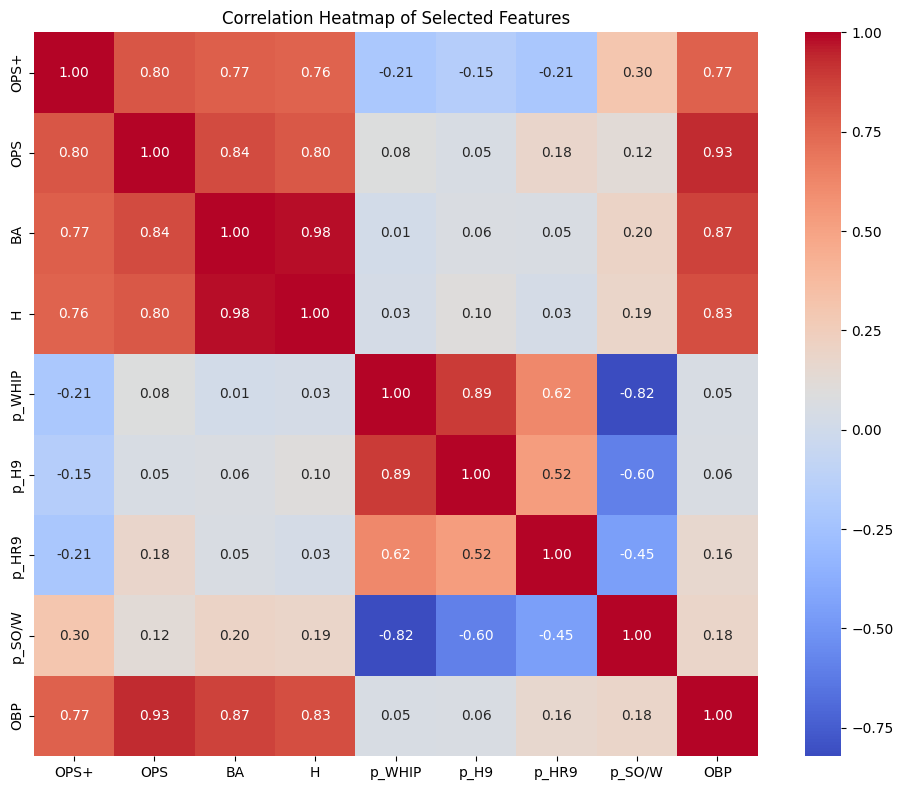

In [221]:
#Correlation Heatmap of Final Features selected by best models

features = ['OPS+', 'OPS', 'BA', 'H', 'p_WHIP', 'p_H9', 'p_HR9', 'p_SO/W', 'OBP']

X_selected = X[features]

corr_matrix = X_selected.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap of Selected Features')
plt.tight_layout()
plt.show()